In [1]:
%cd ~/project/packages/emulator
%load_ext autoreload
%autoreload 2
%matplotlib inline


/home/research_dh/project/packages/emulator


In [2]:
import torch
from torchaudio import load
import numpy as np
from model import Emulator, Unet
from IPython.display import Audio
import os
from utils import get_config, split_mel, cat_mel
from pairDataset import Mel_fn_bigvgan
import matplotlib.pyplot as plt
import librosa as lr
from soundfile import write
import soundfile

In [4]:
x_path = "/home/research_dh/project/data/data/validation/seen/x_50_80_50_50.wav"
x, _ = load(x_path, normalize=False)
x = x[0] / 32768

y_path = "/home/research_dh/project/data/data/validation/seen/y_50_80_50_50.wav"
y, _ = load(y_path, normalize=False)
y = y[0] / 32768


In [5]:
config_dir = "/home/research_dh/project/packages/emulator/config_s_v2.json"
ckpt_dir= "/home/research_dh/project/ckpt/unet/"
model_name = "real_play_s_v2"
device = "cpu"

h = get_config(config_dir)

In [6]:
model = Emulator(model_name, h, ckpt_dir, device)

/home/research_dh/research/lib/python3.8/site-packages/torch/nn/utils/weight_norm.py:134: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
/home/research_dh/project/packages/emulator/model.py:310: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `

unet ckpt loaded
Removing weight norm...


In [ ]:
emb = torch.tensor([0.5, 0.8, 0.5, 0.5])
with torch.no_grad():
    pred = model(x, emb)
pred = pred.to('cpu').squeeze(0).squeeze(0)

torch.Size([1, 1340640])


In [16]:
write("/home/research_dh/project/pred_example.wav", pred, samplerate=h.sampling_rate, subtype='PCM_16')

In [17]:

Audio(pred.to('cpu').numpy(), rate=44100)

torch.Size([1310720])


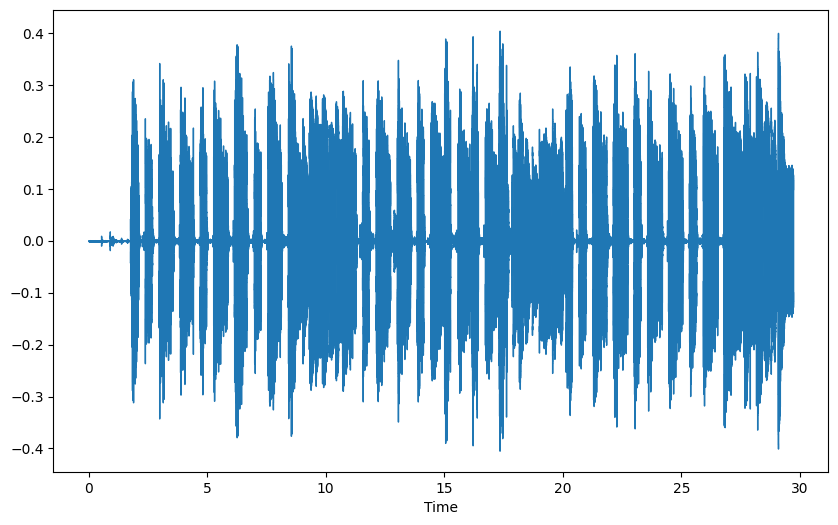

In [21]:
print(pred.shape)

plt.figure(figsize=(10, 6))
lr.display.waveshow(pred.numpy(), sr=h.sampling_rate)
plt.show()


In [14]:
unet = Unet(h)
ckpt = torch.load(os.path.join(ckpt_dir, model_name + ".ckpt"))
unet.load_state_dict(ckpt["model_state_dict"])
unet.eval()
emb = torch.tensor([0.5, 0.8, 0.5, 0.5])
mel_fn = Mel_fn_bigvgan(h.sampling_rate, h.n_fft, h.hop_size, h.n_mels, h.fmin, h.fmax)
with torch.no_grad():
    x_mel = mel_fn(x)
    x_mel = split_mel(x_mel, h.frame_size)
    pred1_mel_split = unet(x_mel, emb)
    pred1_mel = cat_mel(pred1_mel_split)
emb = torch.tensor([0.5, 0.8, 0.8, 0.8])
print(emb)
with torch.no_grad():
    x_mel = mel_fn(x)
    x_mel = split_mel(x_mel, h.frame_size)
    pred2_mel_split = unet(x_mel, emb)
    pred2_mel = cat_mel(pred2_mel_split)

/tmp/ipykernel_239509/4213352174.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(os.path.join(ckpt_dir, model_name + ".ckpt"))


tensor([0.5000, 0.8000, 0.8000, 0.8000])


In [ ]:
loss = torch.nn.L1Loss()
err = 0
y_mel = mel_fn(y)
y_mel_split = split_mel(y_mel, h.frame_size)
for i, m in enumerate(pred1_mel_split):
    err = err + loss(m, y_mel_split[i, ...]).item()
err = err / y_mel_split.shape[0]
print(err)

0.3392013505101204


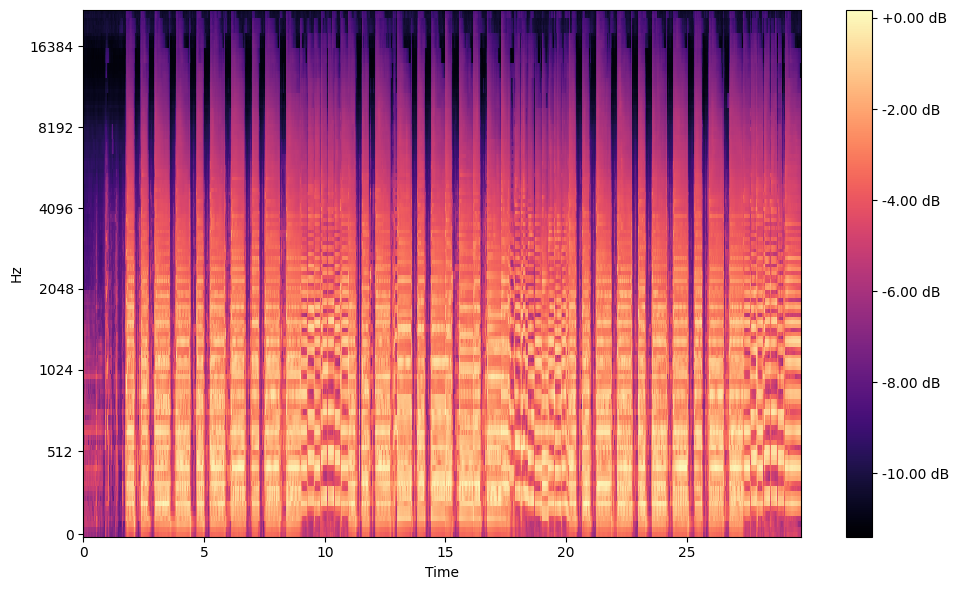

In [18]:
plt.figure(figsize=(10, 6))
lr.display.specshow(pred1_mel.T.numpy(), y_axis='mel', sr=h.sampling_rate, hop_length=h.hop_size, x_axis='time', fmin=h.fmin, fmax=h.fmax)
plt.colorbar(format='%+2.2f dB')
plt.tight_layout()
plt.show()

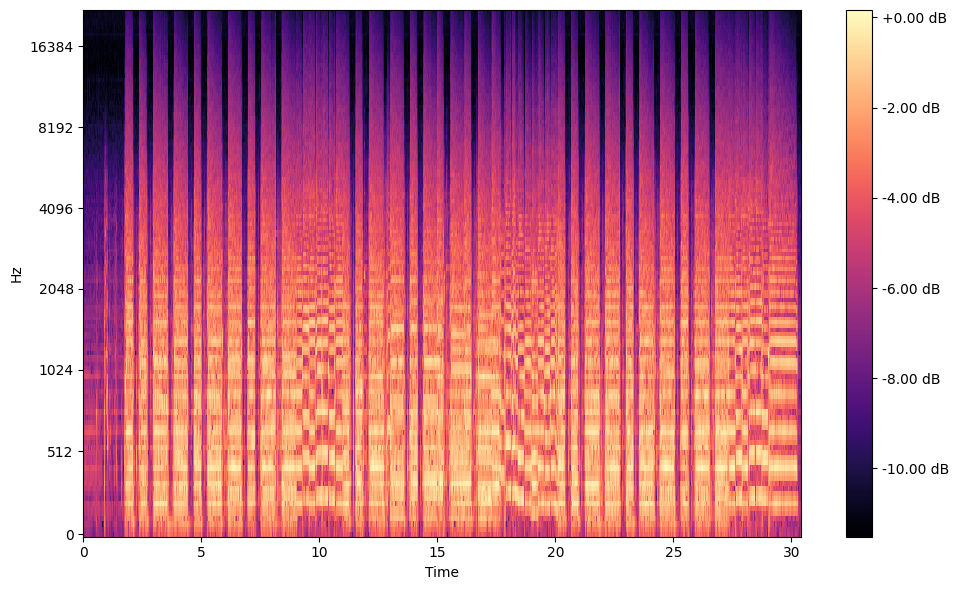

In [57]:
plt.figure(figsize=(10, 6))
lr.display.specshow(y_mel.T.numpy(), y_axis='mel', sr=h.sampling_rate, hop_length=h.hop_size, x_axis='time', fmin=h.fmin, fmax=h.fmax)
plt.colorbar(format='%+2.2f dB')
plt.tight_layout()
plt.show()